<a href="https://colab.research.google.com/github/Tzutzu13/Final_Project2020/blob/master/7_6_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing neccesary libraries and functions**

In [ ]:
  cd /content/drive/Shared drives/USV RECORDINGS/

/content/drive/Shared drives/USV RECORDINGS


In [ ]:
from __future__ import print_function
from keras import backend as K
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras import layers, models
from keras.layers import UpSampling2D,Input,LeakyReLU,MaxPooling2D,Dropout,Lambda,add,Activation,Concatenate,Dense,Flatten,Conv2D
from keras.utils import plot_model
from keras.models import Model
# from keras.layers.convolutional import Conv2D
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import seaborn as sns
def set_callbacks( name = 'best_model_weights',patience=8,tb_base_logdir='./logs/'):
    from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
    cp = ModelCheckpoint(name +'.h5',save_best_only=True)
    es = EarlyStopping(patience=patience,monitor='val_loss')
    rlop = ReduceLROnPlateau(patience=5)
    return [rlop, es, cp]
# def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(5,5)):
#     """
#     Generate matrix plot of confusion matrix with pretty annotations.
#     The plot image is saved to disk.
#     args: 
#       y_true:    true label of the data, with shape (nsamples,)
#       y_pred:    prediction of the data, with shape (nsamples,)
#       filename:  filename of figure file to save
#       labels:    string array, name the order of class labels in the confusion matrix.
#                  use `clf.classes_` if using scikit-learn models.
#                  with shape (nclass,).
#       ymap:      dict: any -> string, length == nclass.
#                  if not None, map the labels & ys to more understandable strings.
#                  Caution: original y_true, y_pred and labels must align.
#       figsize:   the size of the figure plotted.
#     """
#     if ymap is not None:
#         y_pred = [ymap[yi] for yi in y_pred]
#         y_true = [ymap[yi] for yi in y_true]
#         labels = [ymap[yi] for yi in labels]
#     cm = confusion_matrix(y_true, y_pred, labels=labels)
#     cm_sum = np.sum(cm, axis=1, keepdims=True)
#     cm_perc = cm / cm_sum.astype(float) * 100
#     annot = np.empty_like(cm).astype(str)
#     nrows, ncols = cm.shape
#     for i in range(nrows):
#         for j in range(ncols):
#             c = cm[i, j]
#             p = cm_perc[i, j]
#             if i == j:
#                 s = cm_sum[i]
#                 annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
#             elif c == 0:
#                 annot[i, j] = ''
#             else:
#                 annot[i, j] = '%.1f%%\n%d' % (p, c)
#     cm = pd.DataFrame(cm, index=labels, columns=labels)
#     cm.index.name = 'Actual'
#     cm.columns.name = 'Predicted'
#     fig, ax = plt.subplots(figsize=figsize)
#     sns.heatmap(cm, annot=annot, fmt='', ax=ax)
#     plt.savefig(filename)
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,5),filename = None,annot_kws={"size": 20}):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    # Adjust to fit
    label_font = {'size':'18'}
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,annot_kws=annot_kws)
    if filename is not None:
      plt.savefig(filename)
def Remove_None_Data_and_lowering_Labels(data,labels):
    data = [j for i,j in enumerate(data) if j is not None] 
    labels= [j for i,j in enumerate(labels) if j is not None] 
    labels = [str(i) for i in labels]
    labels = [i.lower() for i in labels]
    return data, labels
def build_model(num_classes = 2):
    inp = Input(shape=(img_rows, img_cols,1))
    x = Conv2D(32, (3, 3), padding='same')(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes,activation='softmax')(x)
    return Model(inputs=inp, outputs=x)
def Take_Syllables(Syllable_name,Data,Labels):
    ind = Labels == Syllable_name.lower()
    Syllables = Data[ind]
    return Syllables
def print_loss(hist):
    plt.figure()
    plt.plot(hist.history['loss'], 'r', hist.history['val_loss'], 'b')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('model loss')
    plt.legend(['loss','val_loss'])
    plt.figure()
    plt.plot(hist.history['accuracy'], 'r', hist.history['val_accuracy'], 'b')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.title('model accuracy')
    plt.legend(['accuracy','val_accuracy'])
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0,title = 'plot_title',prob = None, size = 14):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    for i in range(nrow*ncol):
        if preds is not None and i >= len(preds):
          continue
        ax[i//ncol,i%ncol].pcolormesh(20*np.log10(X[skip+i]))

        fig.colorbar(ax[i//ncol,i%ncol].pcolormesh(20*np.log10(X[skip+i])), ax=ax[i//ncol,i%ncol])

        # ax[i//ncol,i%ncol].pcolormesh((X[skip+i]))
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if prob is None:
            ax[i//ncol,i%ncol].set_title([i])
        else:
            ax[i//ncol,i%ncol].set_title('im ' + str(i) +', prob = ' + str(round(prob[i][preds[i]],3)), size = size )
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(int(preds[skip+i])), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='yellow' if y[skip+i]==preds[skip+i] else 'red',weight='bold',fontsize=18)
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(int(y[skip+i])), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold',fontsize=18)
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold',fontsize=18)
    # plt.show()
    fig.suptitle(title,fontweight="bold", size=20)

# fig, (ax0, ax1) = plt.subplots(nrows=2)

# im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
# fig.colorbar(im, ax=ax0)
# ax0.set_title('pcolormesh with levels')


# # contours are *point* based plots, so convert our bound into point
# # centers
# cf = ax1.contourf(x[:-1, :-1] + dx/2.,
#                   y[:-1, :-1] + dy/2., z, levels=levels,
#                   cmap=cmap)
# fig.colorbar(cf, ax=ax1)
# ax1.set_title('contourf with levels')

# # adjust spacing between subplots so `ax1` title and `ax0` tick labels
# # don't overlap
# fig.tight_layout()

# plt.show()

# **Loading Data and build model**

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in log10


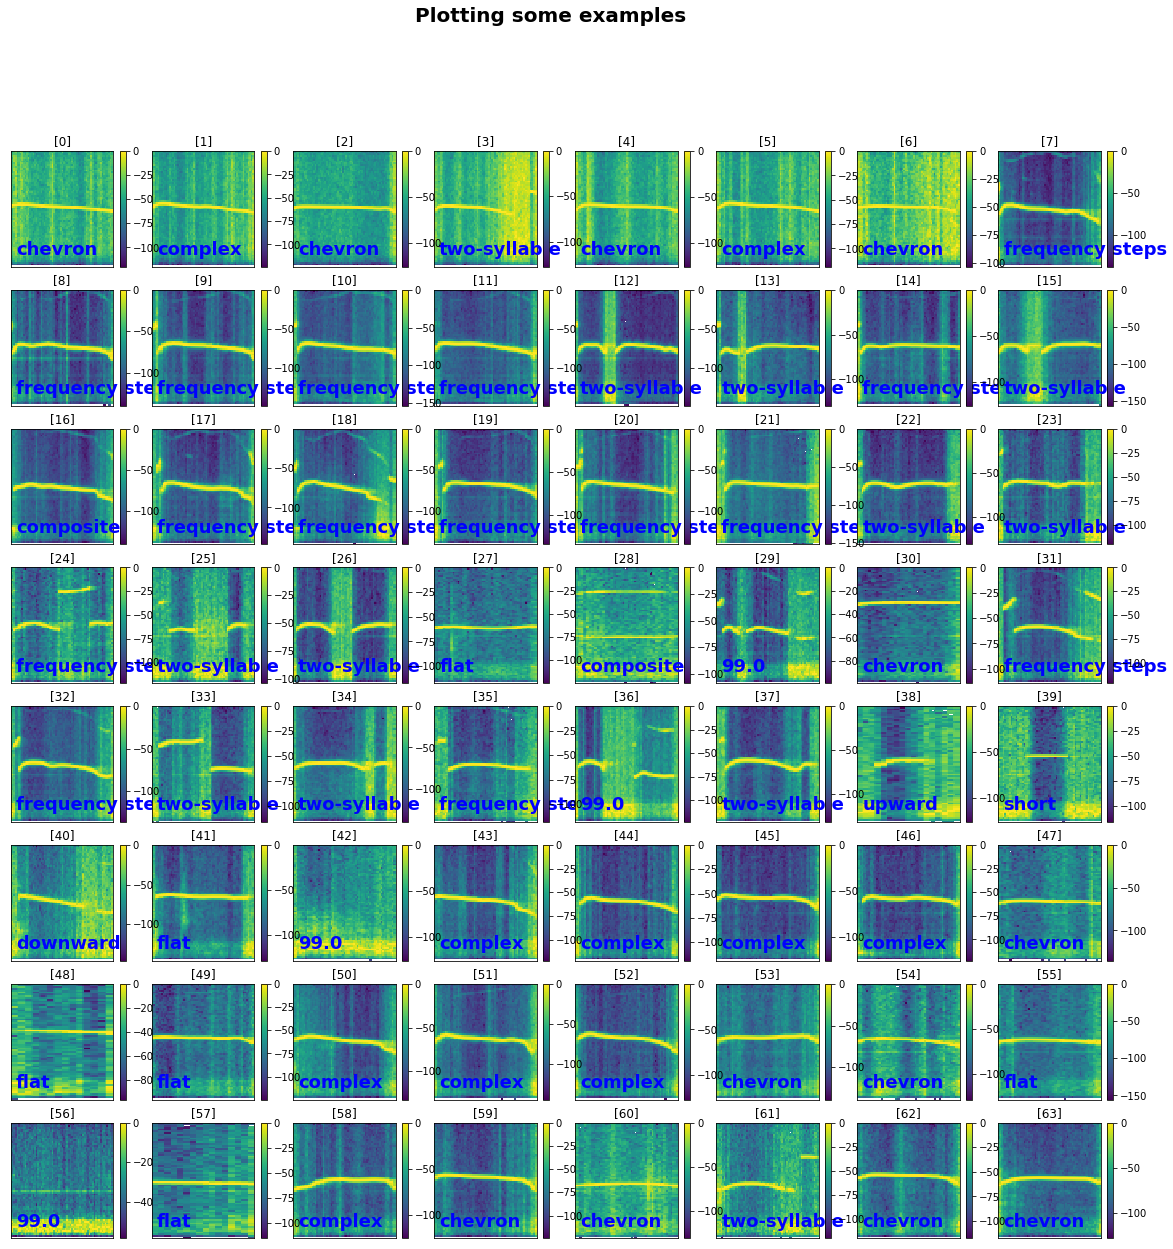

In [ ]:
# %matplotlib qt5
img_rows, img_cols = 64, 64 #choosing resize values
Data_united = np.load('Data_united.npy',allow_pickle = True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data_united = np.array([scaler.fit_transform(i) for i in Data_united])

Labels_united = np.load('Labels_united.npy',allow_pickle = True)

Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
upward_syl = Take_Syllables('upward',Data_united,Labels_united)
flat_syl = Take_Syllables('flat',Data_united,Labels_united)
short_syl = Take_Syllables('short',Data_united,Labels_united)
harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)
downward_syl = Take_Syllables('downward',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
Noise_Labels = 3*np.ones((len(Noise_syl)))

model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
plot_model(model)


#trying united syllables
freq_two = np.concatenate((Frequency_steps_syl,two_syllable_syl))
complex_chevron_flat = np.concatenate((Chevron_syl,Complex_syl,flat_syl))

freq_two_Labels = np.zeros((len(freq_two)))
complex_chevron_flat_Labels = np.ones((len(complex_chevron_flat)))
#plotting some examples

plot_multiple_imgs(Data_united,Labels_united,8,8,figsize = (20,20),skip = 500,title = 'Plotting some examples')


In [ ]:
plot_model(model)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)       

# **Plotting Some Examples (Also in power point presentation)**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


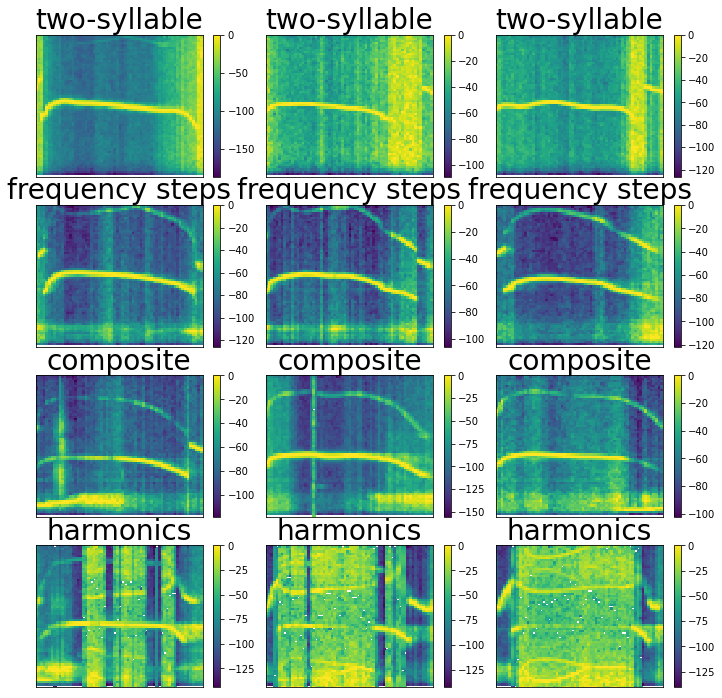

In [ ]:
def plot_Samples(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0,title = 'plot_title',prob = None):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    for i in range(nrow*ncol):
        if preds is not None and i >= len(preds):
          continue
        ax[i//ncol,i%ncol].pcolormesh(20*np.log10(X[skip+i]))
        # ax[i//ncol,i%ncol].pcolormesh((X[skip+i]))
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if prob is None:
            ax[i//ncol,i%ncol].set_title(str(y[skip+i]),size=28)
            fig.colorbar(ax[i//ncol,i%ncol].pcolormesh(20*np.log10(X[skip+i])), ax=ax[i//ncol,i%ncol])

        else:
            ax[i//ncol,i%ncol].set_title('im ' + str(i) +', prob = ' + str(round(prob[i][preds[i]],3)))
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='yellow' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')

# Plotting 3 from each syllable
# Will use for labeling legend
Samples = np.concatenate((Complex_syl[10:13],flat_syl[10:13],Chevron_syl[10:13],short_syl[10:13]))
Samples1 = np.concatenate((two_syllable_syl[50:53],Frequency_steps_syl[30:33],Composite_syl[10:13],harmonics_syl[10:13]))
Samples2 = np.concatenate((downward_syl[10:13],upward_syl[10:13],Noise_syl[11:14]))

Samples_Labels = np.concatenate((Labels_united[Labels_united == 'complex'][0:3],Labels_united[Labels_united == 'flat'][0:3],
                                 Labels_united[Labels_united == 'chevron'][0:3],Labels_united[Labels_united == 'short'][0:3]))
Samples_Labels1 = np.concatenate((Labels_united[Labels_united == 'two-syllable'][0:3],Labels_united[Labels_united == 'frequency steps'][0:3],
                                  Labels_united[Labels_united == 'composite'][0:3],Labels_united[Labels_united == 'harmonics'][0:3]))
                                 
Samples_Labels2 = np.concatenate((Labels_united[Labels_united == 'downward'][0:3],Labels_united[Labels_united == 'upward'][0:3],
                                  ['noise','noise','noise'])) 

# plot_Samples(Samples,Samples_Labels,4,3,figsize = (12,12),title = 'Plotting Syllables')
plot_Samples(Samples1,Samples_Labels1,4,3,figsize = (12,12),title = 'Plotting Syllables')
# plot_Samples(Samples2,Samples_Labels2,3,3,figsize = (12,12),title = 'Plotting Syllables')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


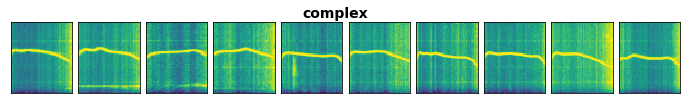

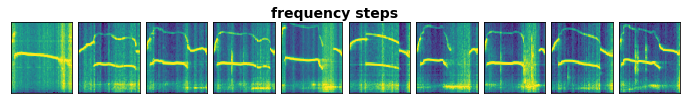

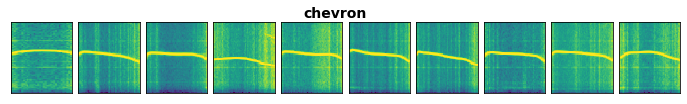

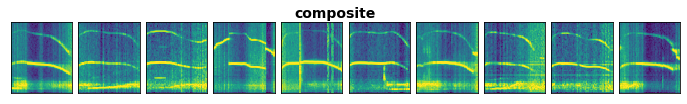

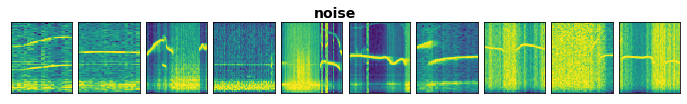

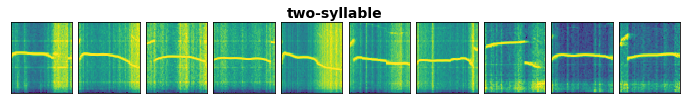

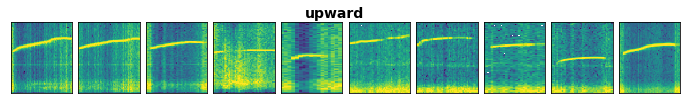

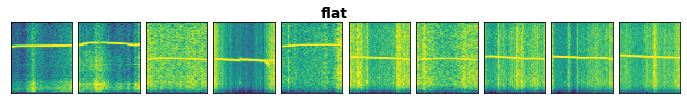

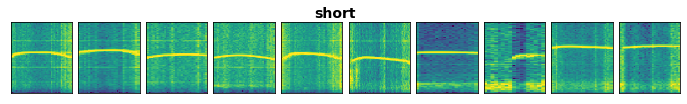

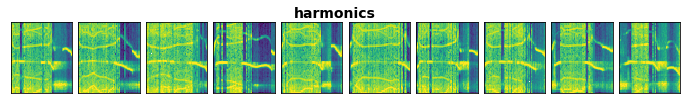

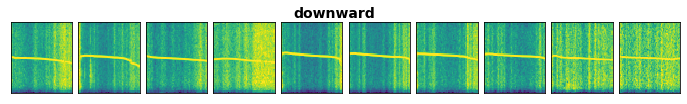

In [ ]:
def plot_Samples_legend(X,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0,title = 'plot_title',prob = None):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(wspace=0.1)
    # ax[0,0].set_title("\n".join(["this is a really long title"]*2))
    for i in range(nrow*ncol):
      if nrow == 1 or ncol == 1:
        ax[i%ncol].pcolormesh(20*np.log10(X[skip+i]))
        ax[i%ncol].set_xticks([])
        ax[i%ncol].set_yticks([])        
      else:
        ax[i//ncol,i%ncol].pcolormesh(20*np.log10(X[skip+i]))
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
    fig.suptitle(title,fontweight="bold", size=14,y = 1.04)
Samples = np.concatenate((Complex_syl[0:10],Frequency_steps_syl[0:10],Chevron_syl[0:10],Composite_syl[0:10],
                          Noise_syl[0:10],two_syllable_syl[0:10],upward_syl[0:10],flat_syl[0:10],
                          short_syl[0:10],harmonics_syl[0:10],downward_syl[0:10]))

Samples_Labels = np.concatenate((Labels_united[Labels_united == 'complex'][0:10],Labels_united[Labels_united == 'frequency steps'][0:10],
                                 Labels_united[Labels_united == 'chevron'][0:10],Labels_united[Labels_united == 'composite'][0:10],
                                 ['noise' for x in range(10)],Labels_united[Labels_united == 'two-syllable'][0:10],
                                 Labels_united[Labels_united == 'upward'][0:10],Labels_united[Labels_united == 'flat'][0:10],
                                 Labels_united[Labels_united == 'short'][0:10],Labels_united[Labels_united == 'harmonics'][0:10],Labels_united[Labels_united == 'downward'][0:10]))
for i in range(11):
  plot_Samples_legend(Samples[i*10:10+i*10],1,10,figsize = (12,1.32),title = Samples_Labels[i*10])

In [ ]:
Labels,Counts = np.unique(Labels_united,return_counts = True)
df = pd.DataFrame({'Labels':Labels,'Counts':Counts})
df = df.sort_values('Counts',ascending=False)
df.Labels[0] = 'noise'
# df.T
df['percent%'] = df.Counts / df.Counts.sum()
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


6        1        2  ...          7      8         4
Labels  frequency steps  chevron  complex  ...  harmonics  short  downward
Counts             1462      860      805  ...        161    156        90

[2 rows x 11 columns]

Text(0.5, 1.0, 'Total of 5891 Labeled Syllables')

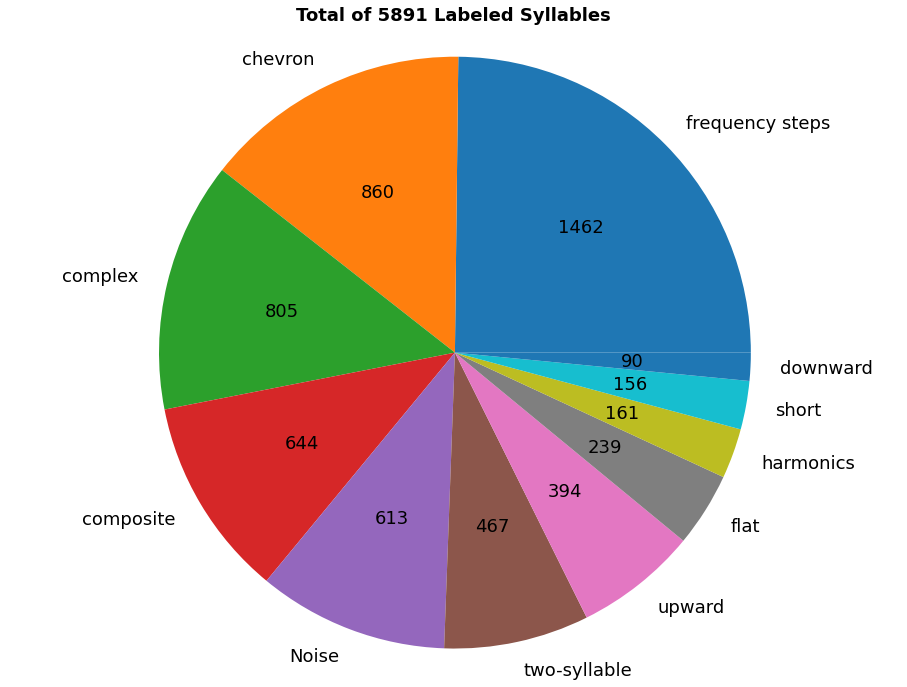

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12), subplot_kw=dict(aspect="equal"))
data = df.Counts.values
Labels = df.Labels.values
def absolute_value(val):
    a  = np.round(val/100.*data.sum(), 0)
    return int(a)
ax.pie(data, labels=Labels,  autopct=absolute_value,textprops={'fontsize': 18})
ax.axis('equal')

ax.set_title("Total of 5891 Labeled Syllables",size = 18,fontweight="bold")

In [ ]:
Labels,Counts = np.unique(Labels_united,return_counts = True)
df = pd.DataFrame({'Labels':Labels,'Counts':Counts})
df = df.sort_values('Counts',ascending=False)
df.Labels[0] = 'Noise'
# df.T
df['percent%'] = df.Counts / df.Counts.sum()
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Labels  Counts  percent%
6   frequency steps    1462  0.248175
1           chevron     860  0.145985
2           complex     805  0.136649
3         composite     644  0.109319
0             Noise     613  0.104057
9      two-syllable     467  0.079273
10           upward     394  0.066882
5              flat     239  0.040570
7         harmonics     161  0.027330
8             short     156  0.026481
4          downward      90  0.015278

In [ ]:
Labels_g = ['complex','chevron','upward','flat','short','downward','composite','two-syllable','harmonics','frequency steps','noise']
Counts_g = [579,527,322,164,143,83,71,37,14,11,2]
df_girls = pd.DataFrame({'Labels':Labels_g,'Counts':Counts_g})
df_girls = df_girls.sort_values('Counts',ascending=False )
df_girls['percent%'] = df_girls.Counts / df_girls.Counts.sum()
df_girls

Labels  Counts  percent%
0           complex     579  0.296467
1           chevron     527  0.269841
2            upward     322  0.164875
3              flat     164  0.083973
4             short     143  0.073221
5          downward      83  0.042499
6         composite      71  0.036354
7      two-syllable      37  0.018945
8         harmonics      14  0.007168
9   frequency steps      11  0.005632
10            noise       2  0.001024

# **Complex vs Freq**

In [ ]:
x = np.concatenate((Complex_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([ 556, 1042]))
(array([0., 1.]), array([123, 205]))
(array([0., 1.]), array([126, 215]))
Train on 1598 samples, validate on 328 samples
Epoch 1/200
1598/1598 [==============================] - 9s 6ms/step - loss: 0.3765 - accuracy: 0.8217 - val_loss: 0.2286 - val_accuracy: 0.9390
Epoch 2/200
1598/1598 [==============================] - 1s 793us/step - loss: 0.1892 - accuracy: 0.9431 - val_loss: 0.1764 - val_accuracy: 0.9573
Epoch 3/200
1598/1598 [==============================] - 1s 805us/step - loss: 0.1281 - accuracy: 0.9618 - val_loss: 0.1433 - val_accuracy: 0.9665
Epoch 4/200
1598/1598 [==============================] - 1s 810us/step - loss: 0.1046 - accuracy: 0.9656 - val_loss: 0.1311 - val_accuracy: 0.9695
Epoch 5/200
1598/1598 [==============================] - 1s 807us/step - loss: 0.0925 - accuracy: 0.9725 - val_loss: 0.1362 - val_accuracy: 0.9726
Epoch 6/200
1598/1598 [==============================] - 1s 799us/step - loss: 0.0752 - accuracy: 0.9762 - 

(array([0, 1]), array([121, 220]))


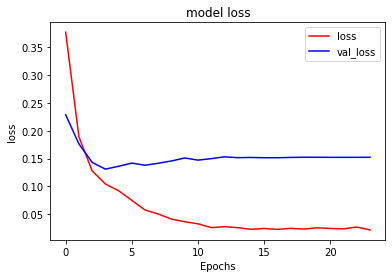

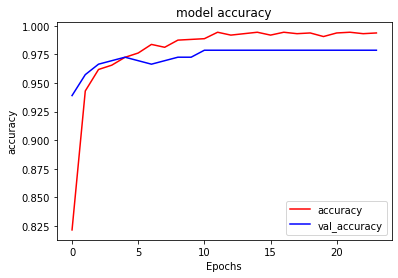

In [ ]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

In [ ]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,5),filename = None,annot_kws={"size": 20}):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    # Adjust to fit
    label_font = {'size':'18'}
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,annot_kws=annot_kws)
    if filename is not None:
      plt.savefig(filename)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in log10


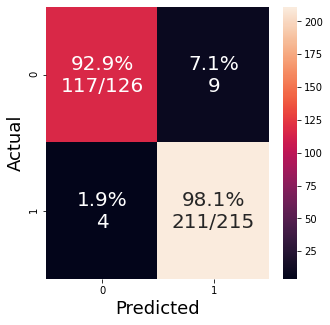

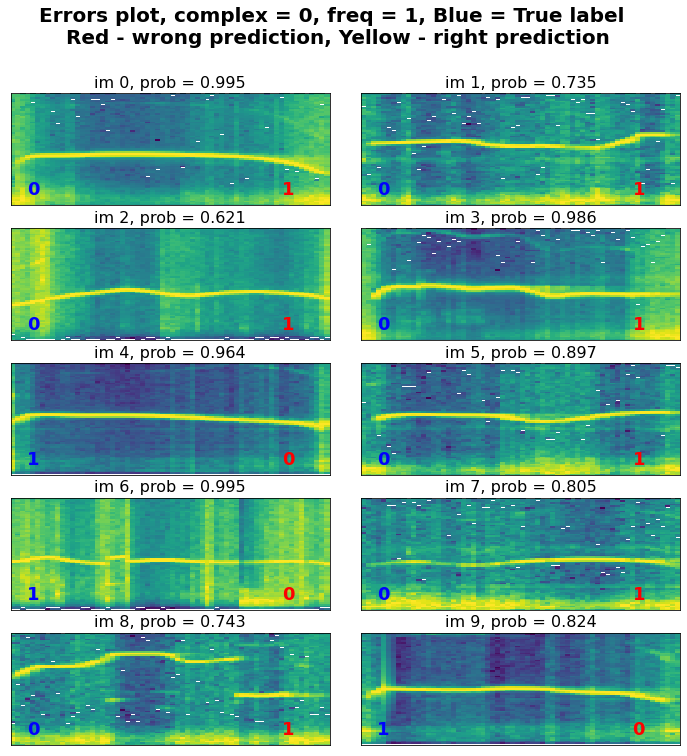

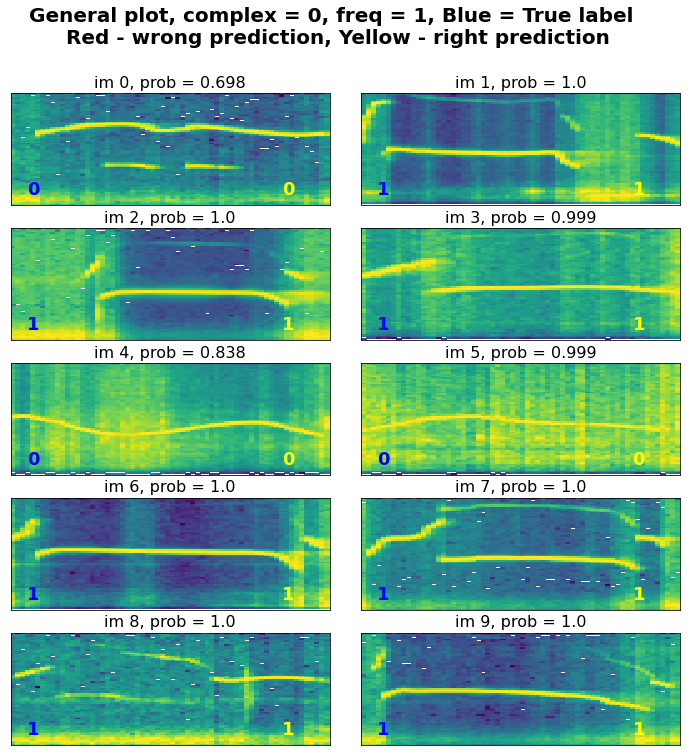

In [ ]:
cm_analysis(y_test, pred, [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,5,2,(12,12),c_pred,title = 'Errors plot, complex = 0, freq = 1, Blue = True label \n Red - wrong prediction, Yellow - right prediction',prob = c_prob, size = 16)
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,5,2,(12,12),pred,title = 'General plot, complex = 0, freq = 1, Blue = True label \n Red - wrong prediction, Yellow - right prediction',prob = predictions, size = 16)


# **Complex vs Freq with data augmentation**

---



In [ ]:
x = np.concatenate((Complex_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([ 556, 1042]))
(array([0., 1.]), array([123, 205]))
(array([0., 1.]), array([126, 215]))
Epoch 1/200
13/12 [===============================] - 1s 94ms/step - loss: 0.4424 - accuracy: 0.7597 - val_loss: 0.4017 - val_accuracy: 0.8841
Epoch 2/200
13/12 [===============================] - 1s 66ms/step - loss: 0.2438 - accuracy: 0.9268 - val_loss: 0.1836 - val_accuracy: 0.9482
Epoch 3/200
13/12 [===============================] - 1s 66ms/step - loss: 0.1787 - accuracy: 0.9518 - val_loss: 0.1585 - val_accuracy: 0.9573
Epoch 4/200
13/12 [===============================] - 1s 69ms/step - loss: 0.1270 - accuracy: 0.9606 - val_loss: 0.1357 - val_accuracy: 0.9665
Epoch 5/200
13/12 [===============================] - 1s 75ms/step - loss: 0.1191 - accuracy: 0.9625 - val_loss: 0.1353 - val_accuracy: 0.9695
Epoch 6/200
13/12 [===============================] - 1s 63ms/step - loss: 0.0989 - accuracy: 0.9675 - val_loss: 0.1312 - val_accuracy: 0.9756
Epoch 7/200
13/12 [==========

(array([0, 1]), array([123, 218]))


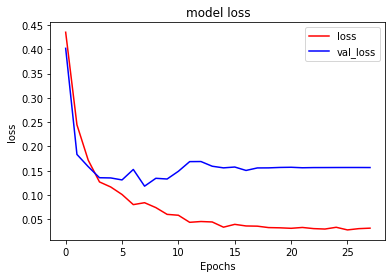

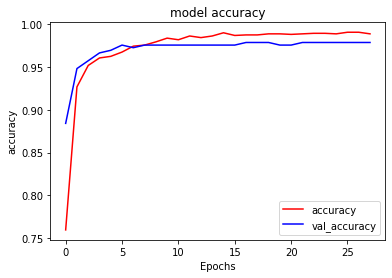

In [ ]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in log10


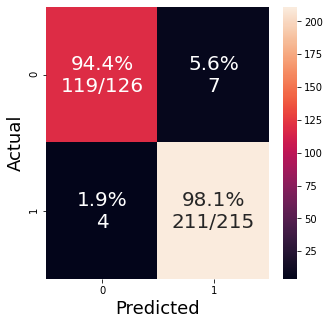

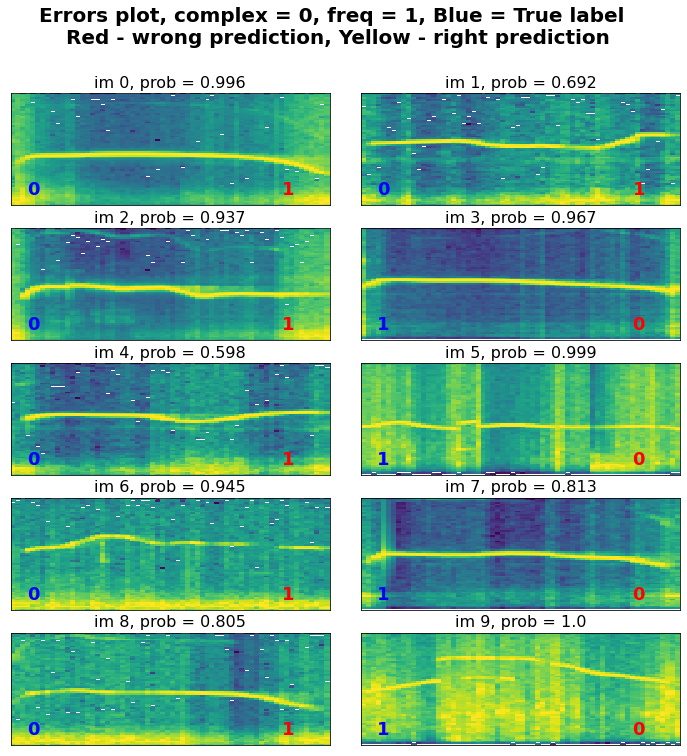

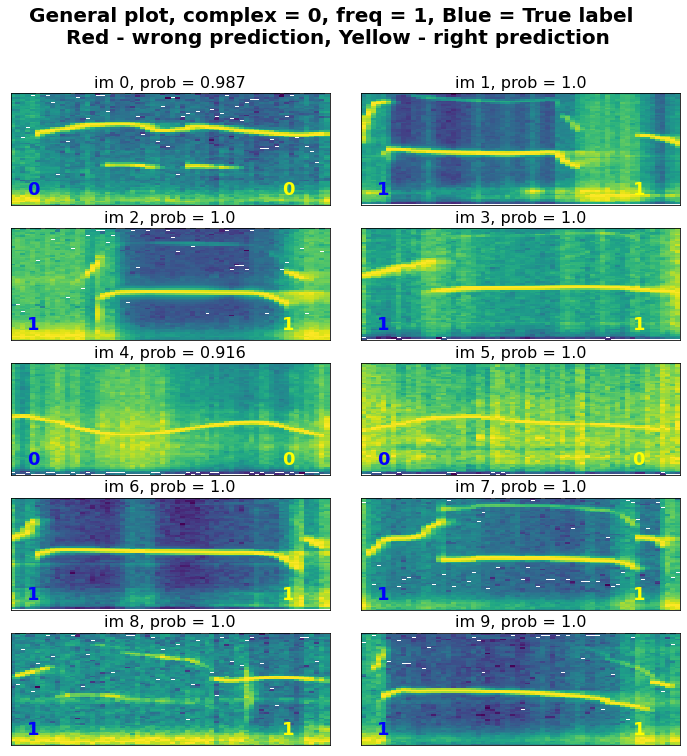

In [ ]:
cm_analysis(y_test, pred, [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,5,2,(12,12),c_pred,title = 'Errors plot, complex = 0, freq = 1, Blue = True label \n Red - wrong prediction, Yellow - right prediction',prob = c_prob, size = 16)
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,5,2,(12,12),pred,title = 'General plot, complex = 0, freq = 1, Blue = True label \n Red - wrong prediction, Yellow - right prediction',prob = predictions, size = 16)


# **Complex_Chevron_Flat Vs Frequency_Two syll**

In [ ]:
complex_chevron_flat = np.concatenate((Chevron_syl,Complex_syl,flat_syl))
freq_two = np.concatenate((Frequency_steps_syl,two_syllable_syl))

complex_chevron_flat_Labels = np.zeros((len(complex_chevron_flat)))
freq_two_Labels = np.ones((len(freq_two)))


In [ ]:
x = np.concatenate((freq_two,complex_chevron_flat))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((freq_two_Labels,complex_chevron_flat_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([1369, 1335]))
(array([0., 1.]), array([275, 279]))
(array([0., 1.]), array([260, 315]))
Train on 2704 samples, validate on 554 samples
Epoch 1/200
2704/2704 [==============================] - 2s 651us/step - loss: 0.3731 - accuracy: 0.8317 - val_loss: 0.2149 - val_accuracy: 0.9368
Epoch 2/200
2704/2704 [==============================] - 1s 420us/step - loss: 0.2211 - accuracy: 0.9183 - val_loss: 0.2048 - val_accuracy: 0.9332
Epoch 3/200
2704/2704 [==============================] - 1s 423us/step - loss: 0.1933 - accuracy: 0.9301 - val_loss: 0.1840 - val_accuracy: 0.9513
Epoch 4/200
2704/2704 [==============================] - 1s 423us/step - loss: 0.1701 - accuracy: 0.9405 - val_loss: 0.1662 - val_accuracy: 0.9440
Epoch 5/200
2704/2704 [==============================] - 1s 421us/step - loss: 0.1450 - accuracy: 0.9493 - val_loss: 0.1728 - val_accuracy: 0.9440
Epoch 6/200
2704/2704 [==============================] - 1s 421us/step - loss: 0.1311 - accuracy: 0.9582 

(array([0, 1]), array([264, 311]))


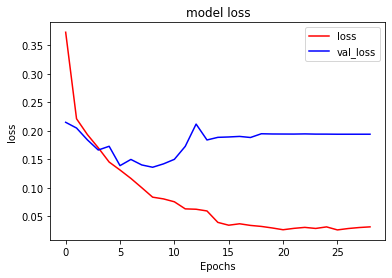

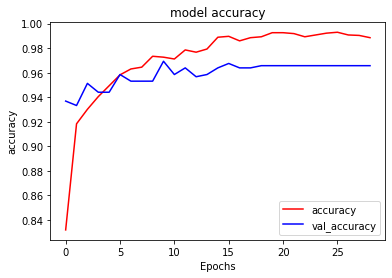

In [ ]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in log10


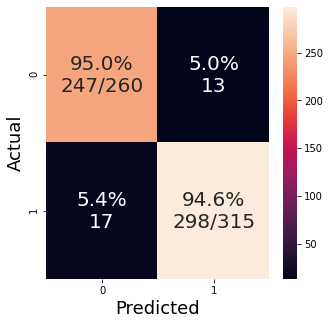

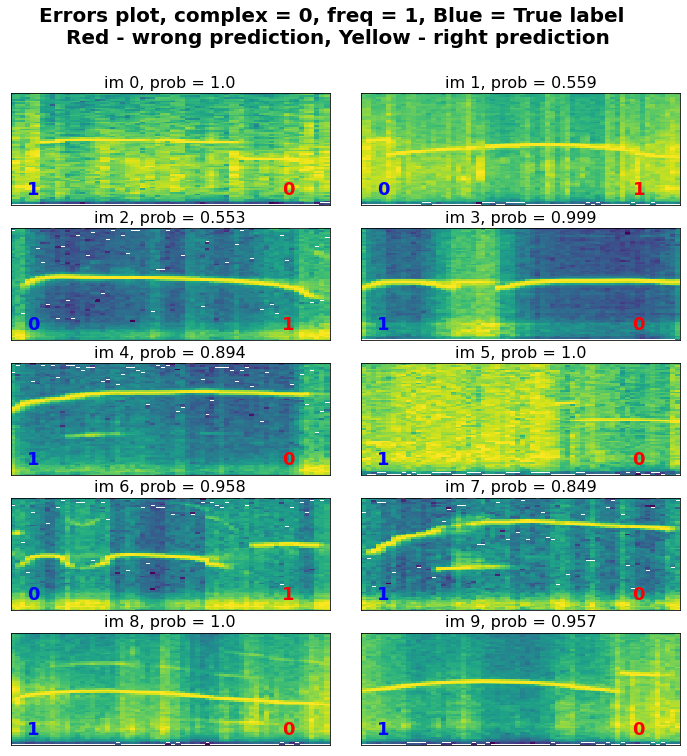

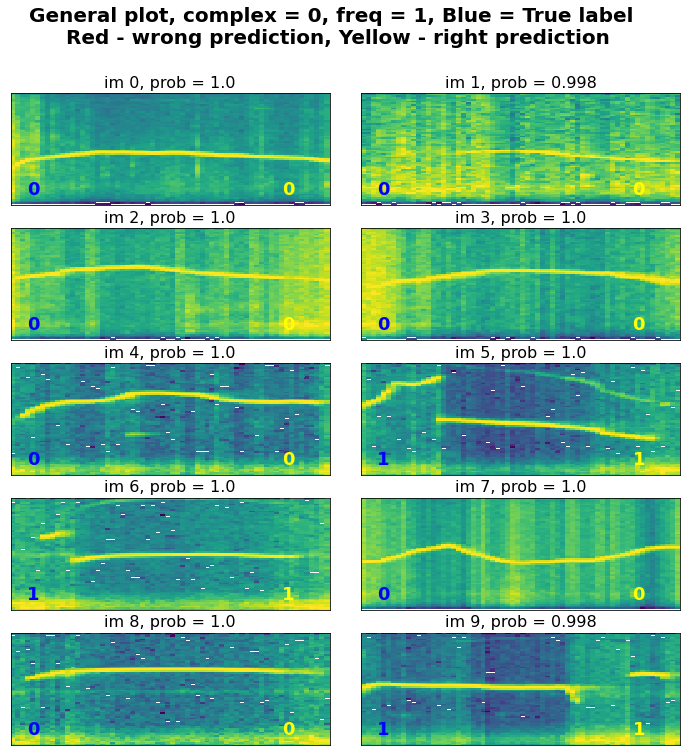

In [ ]:
cm_analysis(y_test, pred, [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,5,2,(12,12),c_pred,title = 'Errors plot, complex = 0, freq = 1, Blue = True label \n Red - wrong prediction, Yellow - right prediction',prob = c_prob, size = 16)
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,5,2,(12,12),pred,title = 'General plot, complex = 0, freq = 1, Blue = True label \n Red - wrong prediction, Yellow - right prediction',prob = predictions, size = 16)


# **Complex_Chevron_Flat Vs Frequency_Two syll with data augmentation**

---



---



In [ ]:
x = np.concatenate((freq_two,complex_chevron_flat))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((freq_two_Labels,complex_chevron_flat_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([1369, 1335]))
(array([0., 1.]), array([275, 279]))
(array([0., 1.]), array([260, 315]))
Epoch 1/200
22/21 [===============================] - 2s 80ms/step - loss: 0.3885 - accuracy: 0.8328 - val_loss: 0.2415 - val_accuracy: 0.9224
Epoch 2/200
22/21 [===============================] - 1s 68ms/step - loss: 0.2291 - accuracy: 0.9120 - val_loss: 0.1849 - val_accuracy: 0.9422
Epoch 3/200
22/21 [===============================] - 2s 70ms/step - loss: 0.2165 - accuracy: 0.9227 - val_loss: 0.1675 - val_accuracy: 0.9513
Epoch 4/200
22/21 [===============================] - 1s 67ms/step - loss: 0.1814 - accuracy: 0.9379 - val_loss: 0.1787 - val_accuracy: 0.9422
Epoch 5/200
22/21 [===============================] - 2s 69ms/step - loss: 0.1765 - accuracy: 0.9456 - val_loss: 0.1634 - val_accuracy: 0.9332
Epoch 6/200
22/21 [===============================] - 2s 69ms/step - loss: 0.1607 - accuracy: 0.9430 - val_loss: 0.1458 - val_accuracy: 0.9639
Epoch 7/200
22/21 [==========

(array([0, 1]), array([262, 313]))


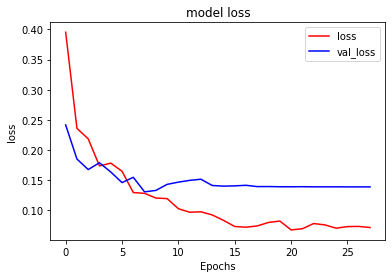

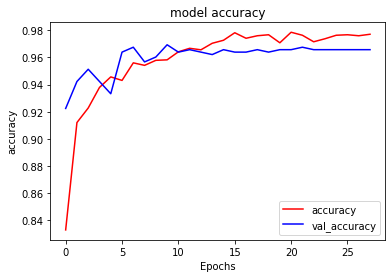

In [ ]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in log10


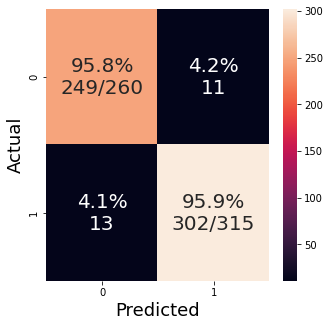

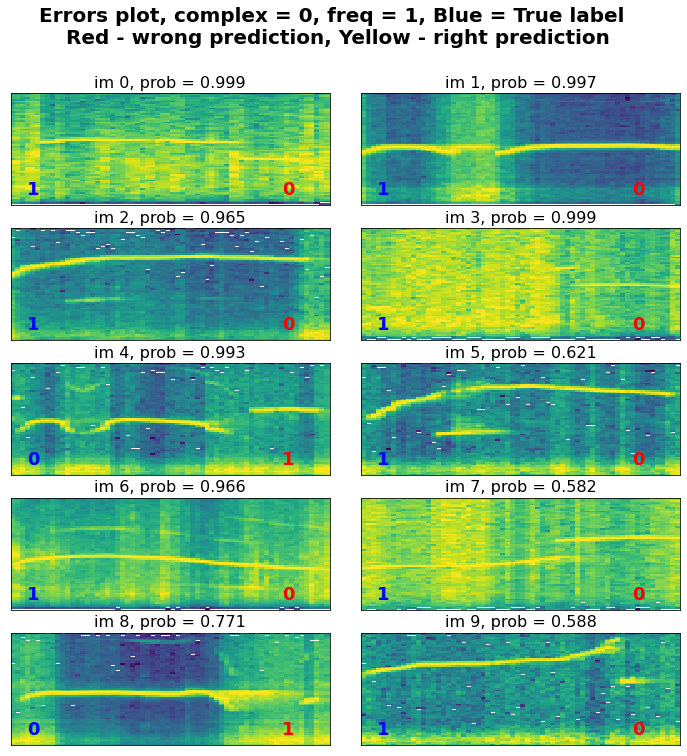

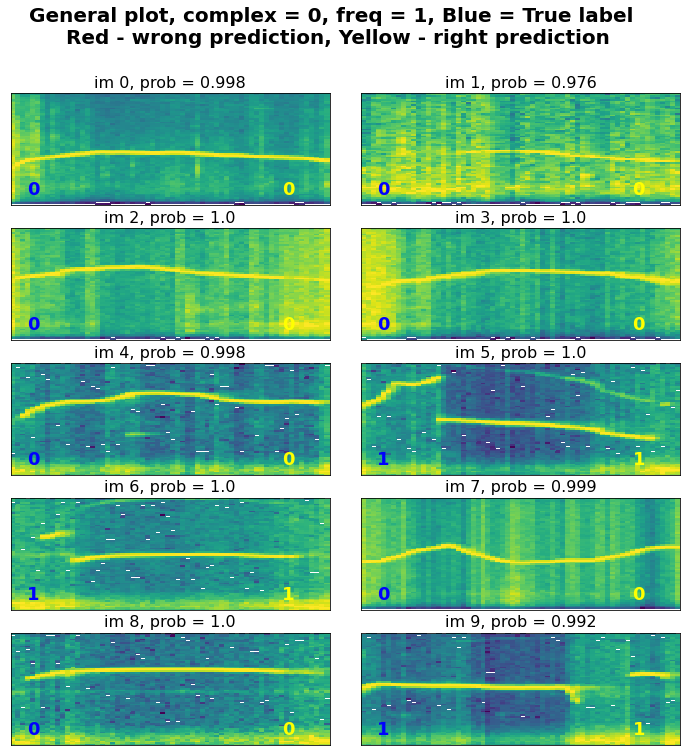

In [ ]:
cm_analysis(y_test, pred, [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,5,2,(12,12),c_pred,title = 'Errors plot, complex = 0, freq = 1, Blue = True label \n Red - wrong prediction, Yellow - right prediction',prob = c_prob, size = 16)
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,5,2,(12,12),pred,title = 'General plot, complex = 0, freq = 1, Blue = True label \n Red - wrong prediction, Yellow - right prediction',prob = predictions, size = 16)


# **Freq Vs Chevron**

In [ ]:
Chevron_Labels = np.zeros((len(Chevron_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
x = np.concatenate((Chevron_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((Chevron_Labels,freq_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([ 617, 1020]))
(array([0., 1.]), array([108, 228]))
(array([0., 1.]), array([135, 214]))
Train on 1637 samples, validate on 336 samples
Epoch 1/200
1637/1637 [==============================] - 2s 1ms/step - loss: 0.4191 - accuracy: 0.7679 - val_loss: 0.2143 - val_accuracy: 0.9315
Epoch 2/200
1637/1637 [==============================] - 1s 425us/step - loss: 0.2104 - accuracy: 0.9181 - val_loss: 0.1671 - val_accuracy: 0.9405
Epoch 3/200
1637/1637 [==============================] - 1s 420us/step - loss: 0.1572 - accuracy: 0.9450 - val_loss: 0.1304 - val_accuracy: 0.9554
Epoch 4/200
1637/1637 [==============================] - 1s 420us/step - loss: 0.1181 - accuracy: 0.9597 - val_loss: 0.1249 - val_accuracy: 0.9583
Epoch 5/200
1637/1637 [==============================] - 1s 420us/step - loss: 0.0968 - accuracy: 0.9688 - val_loss: 0.1363 - val_accuracy: 0.9524
Epoch 6/200
1637/1637 [==============================] - 1s 423us/step - loss: 0.0766 - accuracy: 0.9750 - 

(array([0, 1]), array([138, 211]))


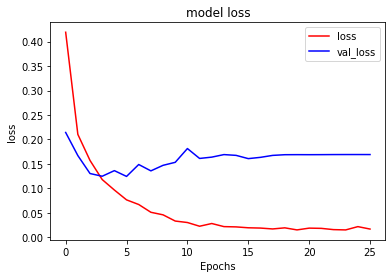

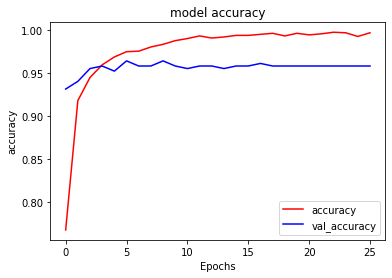

In [ ]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in log10


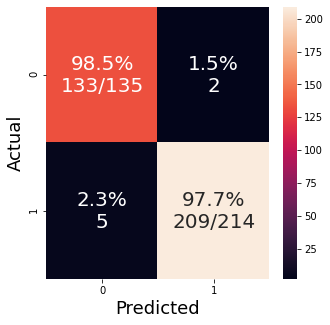

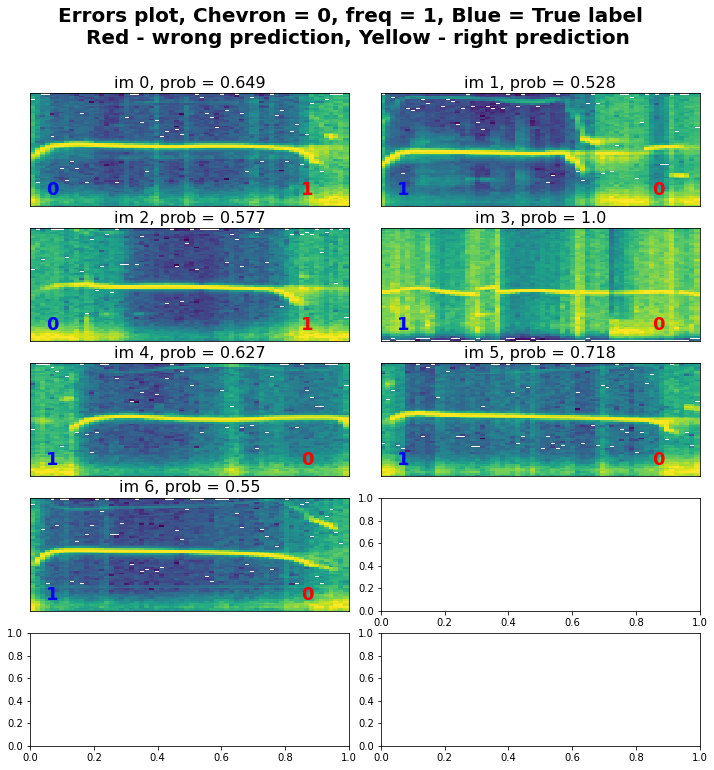

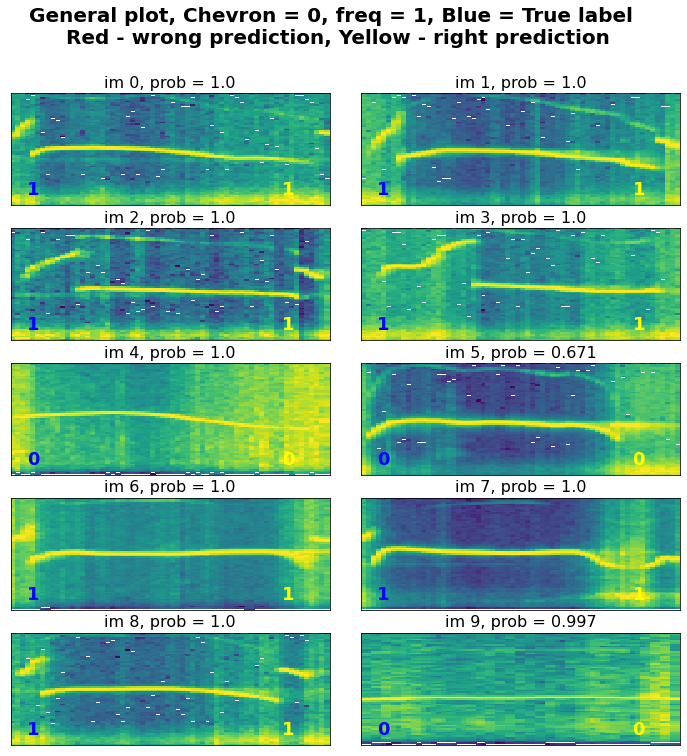

In [ ]:
cm_analysis(y_test, pred, [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,5,2,(12,12),c_pred,title = 'Errors plot, Chevron = 0, freq = 1, Blue = True label \n Red - wrong prediction, Yellow - right prediction',prob = c_prob, size = 16)
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,5,2,(12,12),pred,title = 'General plot, Chevron = 0, freq = 1, Blue = True label \n Red - wrong prediction, Yellow - right prediction',prob = predictions, size = 16)


# **Freq Vs Chevron with data augmentation**

---



In [ ]:
Chevron_Labels = np.zeros((len(Chevron_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
x = np.concatenate((Chevron_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((Chevron_Labels,freq_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=2)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1.]), array([ 617, 1020]))
(array([0., 1.]), array([108, 228]))
(array([0., 1.]), array([135, 214]))
Epoch 1/200
13/12 [==============================] - 1s 97ms/step - loss: 0.4338 - accuracy: 0.7703 - val_loss: 0.2997 - val_accuracy: 0.8958
Epoch 2/200
13/12 [==============================] - 1s 64ms/step - loss: 0.2094 - accuracy: 0.9200 - val_loss: 0.1720 - val_accuracy: 0.9435
Epoch 3/200
13/12 [==============================] - 1s 69ms/step - loss: 0.1517 - accuracy: 0.9469 - val_loss: 0.1360 - val_accuracy: 0.9494
Epoch 4/200
13/12 [==============================] - 1s 68ms/step - loss: 0.1139 - accuracy: 0.9585 - val_loss: 0.1161 - val_accuracy: 0.9673
Epoch 5/200
13/12 [==============================] - 1s 67ms/step - loss: 0.1079 - accuracy: 0.9646 - val_loss: 0.1182 - val_accuracy: 0.9613
Epoch 6/200
13/12 [==============================] - 1s 68ms/step - loss: 0.0826 - accuracy: 0.9731 - val_loss: 0.1103 - val_accuracy: 0.9643
Epoch 7/200
13/12 [================

(array([0, 1]), array([135, 214]))


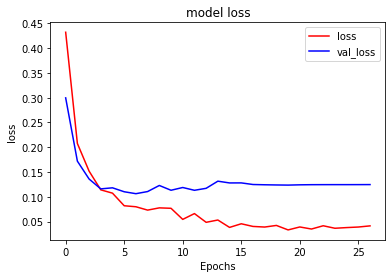

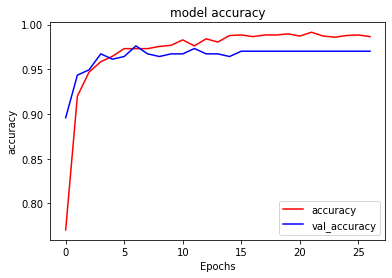

In [ ]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in log10


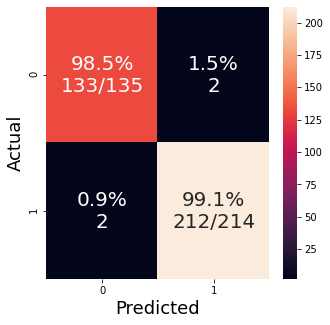

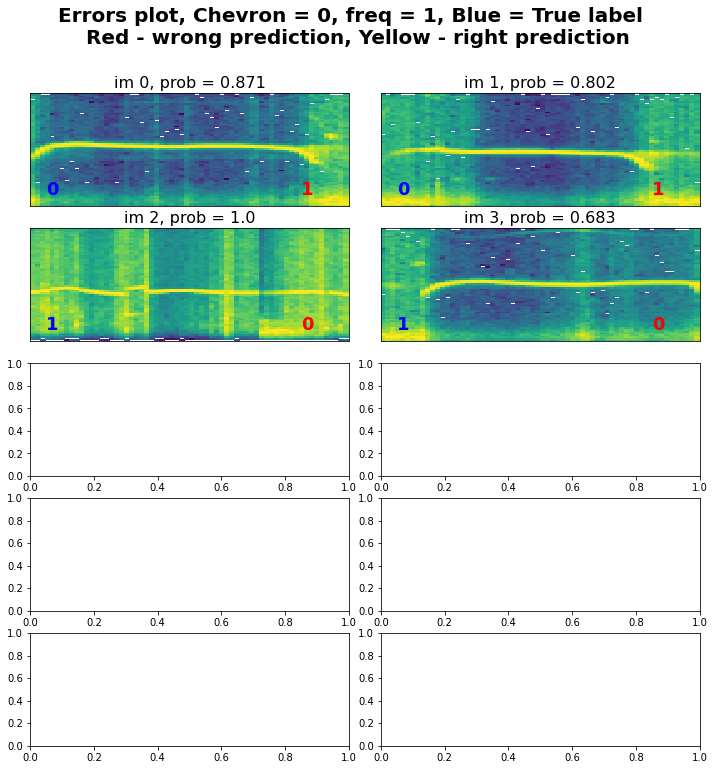

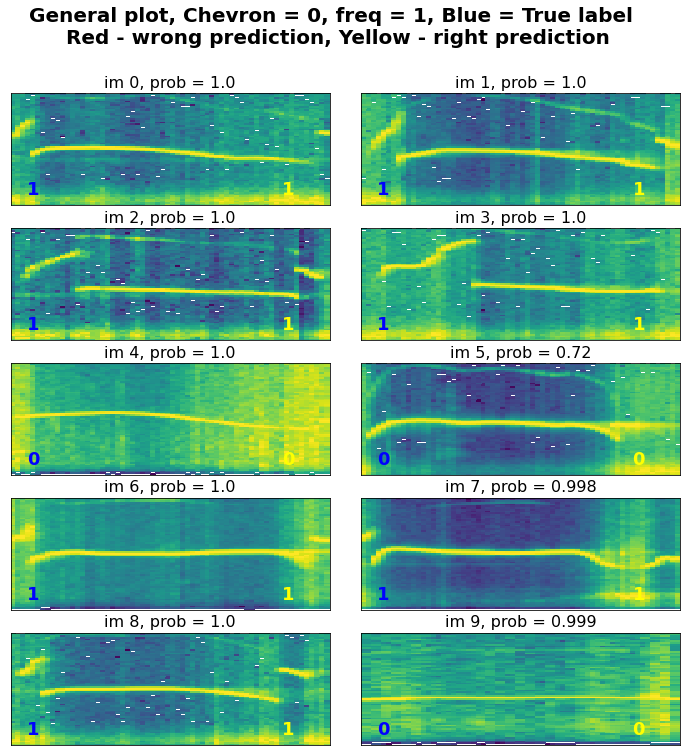

In [ ]:
cm_analysis(y_test, pred, [0,1])

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,5,2,(12,12),c_pred,title = 'Errors plot, Chevron = 0, freq = 1, Blue = True label \n Red - wrong prediction, Yellow - right prediction',prob = c_prob, size = 16)
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,5,2,(12,12),pred,title = 'General plot, Chevron = 0, freq = 1, Blue = True label \n Red - wrong prediction, Yellow - right prediction',prob = predictions, size = 16)


# **Freq Vs complex vs composite**


In [ ]:
Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
# Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
# Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
# two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
# flat_syl = Take_Syllables('flat',Data_united,Labels_united)
# harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
# Noise_Labels = 3*np.ones((len(Composite_syl)))

In [ ]:
x = np.concatenate((Complex_syl,Frequency_steps_syl,Composite_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels,composite_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=3)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1., 2.]), array([ 566, 1032,  455]))
(array([0., 1., 2.]), array([115, 206, 100]))
(array([0., 1., 2.]), array([124, 224,  89]))
Train on 2053 samples, validate on 421 samples
Epoch 1/200
2053/2053 [==============================] - 2s 1ms/step - loss: 0.6280 - accuracy: 0.7175 - val_loss: 0.3752 - val_accuracy: 0.8646
Epoch 2/200
2053/2053 [==============================] - 2s 811us/step - loss: 0.3626 - accuracy: 0.8777 - val_loss: 0.3004 - val_accuracy: 0.9026
Epoch 3/200
2053/2053 [==============================] - 2s 808us/step - loss: 0.2867 - accuracy: 0.9050 - val_loss: 0.2904 - val_accuracy: 0.9002
Epoch 4/200
2053/2053 [==============================] - 2s 800us/step - loss: 0.2391 - accuracy: 0.9235 - val_loss: 0.2979 - val_accuracy: 0.9050
Epoch 5/200
2053/2053 [==============================] - 2s 801us/step - loss: 0.2289 - accuracy: 0.9255 - val_loss: 0.2855 - val_accuracy: 0.9121
Epoch 6/200
2053/2053 [==============================] - 2s 809us/step - loss: 

(array([0, 1, 2]), array([125, 226,  86]))


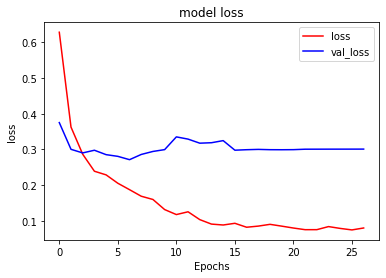

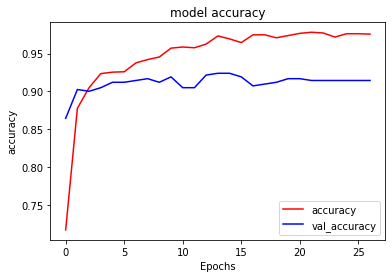

In [ ]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in log10


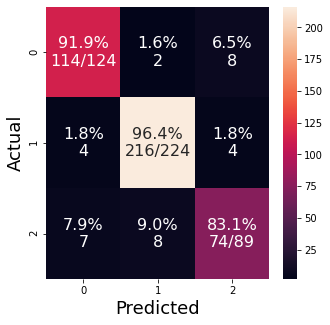

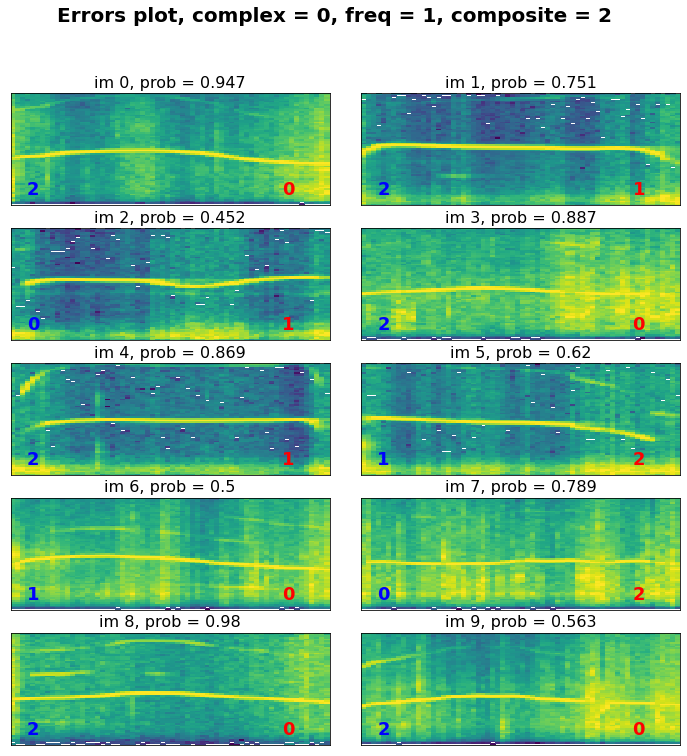

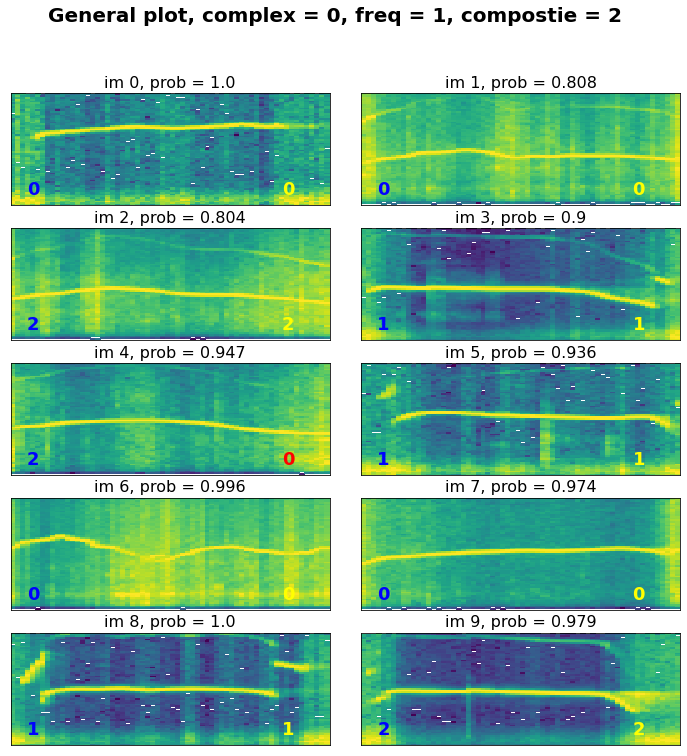

In [ ]:
cm_analysis(y_test, pred, [0,1,2],annot_kws={"size": 16})

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,5,2,(12,12),c_pred,title = 'Errors plot, complex = 0, freq = 1, composite = 2',prob = c_prob, size = 16)
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,5,2,(12,12),pred,title = 'General plot, complex = 0, freq = 1, compostie = 2',prob = predictions, size = 16)


# **Freq Vs complex vs composite with data augmentation**


In [ ]:
Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
# Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
# Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
# two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
# flat_syl = Take_Syllables('flat',Data_united,Labels_united)
# harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
# Noise_Labels = 3*np.ones((len(Composite_syl)))

In [ ]:
x = np.concatenate((Complex_syl,Frequency_steps_syl,Composite_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels,composite_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=3)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1., 2.]), array([ 566, 1032,  455]))
(array([0., 1., 2.]), array([115, 206, 100]))
(array([0., 1., 2.]), array([124, 224,  89]))
Epoch 1/200
17/16 [===============================] - 2s 137ms/step - loss: 0.7449 - accuracy: 0.6736 - val_loss: 0.4936 - val_accuracy: 0.8314
Epoch 2/200
17/16 [===============================] - 2s 101ms/step - loss: 0.4270 - accuracy: 0.8490 - val_loss: 0.3486 - val_accuracy: 0.8812
Epoch 3/200
17/16 [===============================] - 2s 102ms/step - loss: 0.3338 - accuracy: 0.8850 - val_loss: 0.3197 - val_accuracy: 0.8907
Epoch 4/200
17/16 [===============================] - 2s 101ms/step - loss: 0.2884 - accuracy: 0.8972 - val_loss: 0.3095 - val_accuracy: 0.9026
Epoch 5/200
17/16 [===============================] - 2s 101ms/step - loss: 0.2794 - accuracy: 0.9079 - val_loss: 0.2929 - val_accuracy: 0.9097
Epoch 6/200
17/16 [===============================] - 2s 127ms/step - loss: 0.2512 - accuracy: 0.9118 - val_loss: 0.2794 - val_accuracy: 0.

(array([0, 1, 2]), array([124, 227,  86]))


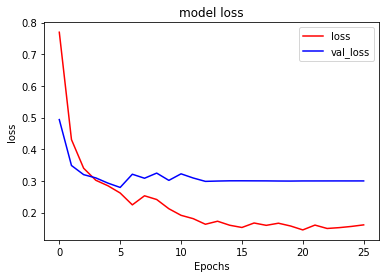

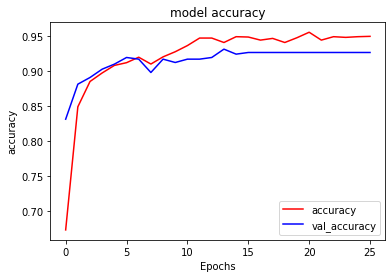

In [ ]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in log10


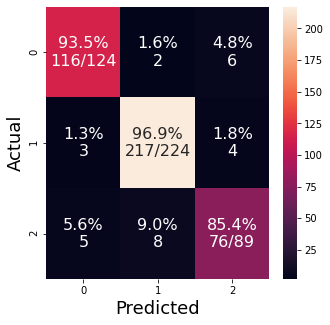

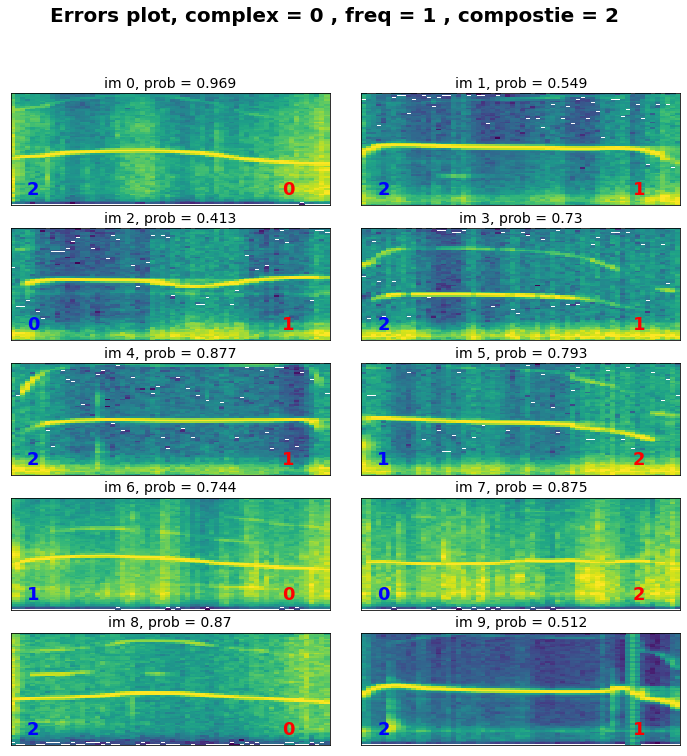

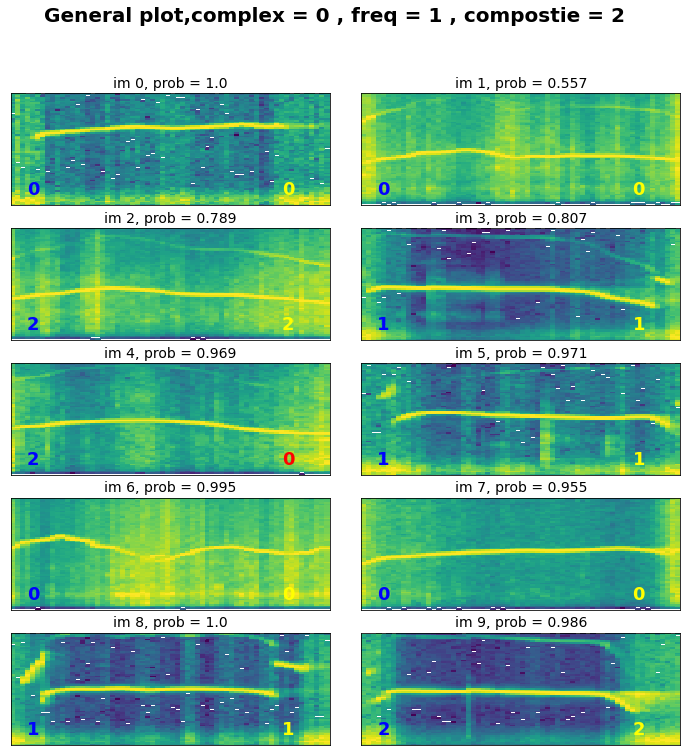

In [ ]:
cm_analysis(y_test, pred, [0,1,2],annot_kws={"size": 16})

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,5,2,(12,12),c_pred,title = 'Errors plot, complex = 0 , freq = 1 , compostie = 2',prob = c_prob)
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,5,2,(12,12),pred,title = 'General plot,complex = 0 , freq = 1 , compostie = 2',prob = predictions)


# **Freq Vs complex vs composite vs noise**


In [ ]:
Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
# Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
# two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
# flat_syl = Take_Syllables('flat',Data_united,Labels_united)
# harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
Noise_Labels = 3*np.ones((len(Noise_syl)))

In [ ]:
x = np.concatenate((Complex_syl,Frequency_steps_syl,Composite_syl,Noise_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels,composite_Labels,Noise_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=4)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
hist = model.fit(X_train,y_train ,validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,batch_size = 128,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1., 2., 3.]), array([ 552, 1051,  457,  425]))
(array([0., 1., 2., 3.]), array([110, 207,  94,  99]))
(array([0., 1., 2., 3.]), array([143, 204,  93,  89]))
Train on 2485 samples, validate on 510 samples
Epoch 1/200
2485/2485 [==============================] - 3s 1ms/step - loss: 0.8661 - accuracy: 0.6543 - val_loss: 0.5549 - val_accuracy: 0.8373
Epoch 2/200
2485/2485 [==============================] - 2s 807us/step - loss: 0.5282 - accuracy: 0.8229 - val_loss: 0.4634 - val_accuracy: 0.8392
Epoch 3/200
2485/2485 [==============================] - 2s 800us/step - loss: 0.4544 - accuracy: 0.8402 - val_loss: 0.4238 - val_accuracy: 0.8569
Epoch 4/200
2485/2485 [==============================] - 2s 810us/step - loss: 0.4097 - accuracy: 0.8628 - val_loss: 0.3877 - val_accuracy: 0.8745
Epoch 5/200
2485/2485 [==============================] - 2s 803us/step - loss: 0.3729 - accuracy: 0.8753 - val_loss: 0.3802 - val_accuracy: 0.8804
Epoch 6/200
2485/2485 [============================

(array([0, 1, 2, 3]), array([141, 213,  94,  81]))


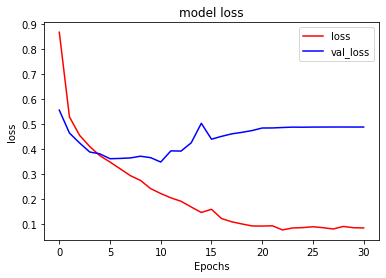

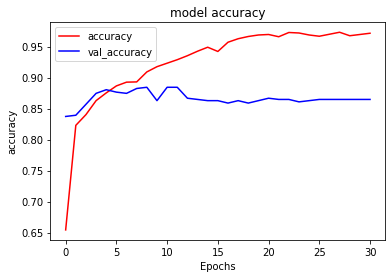

In [ ]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in log10


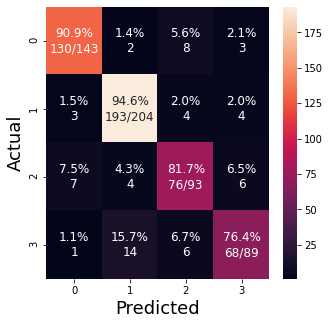

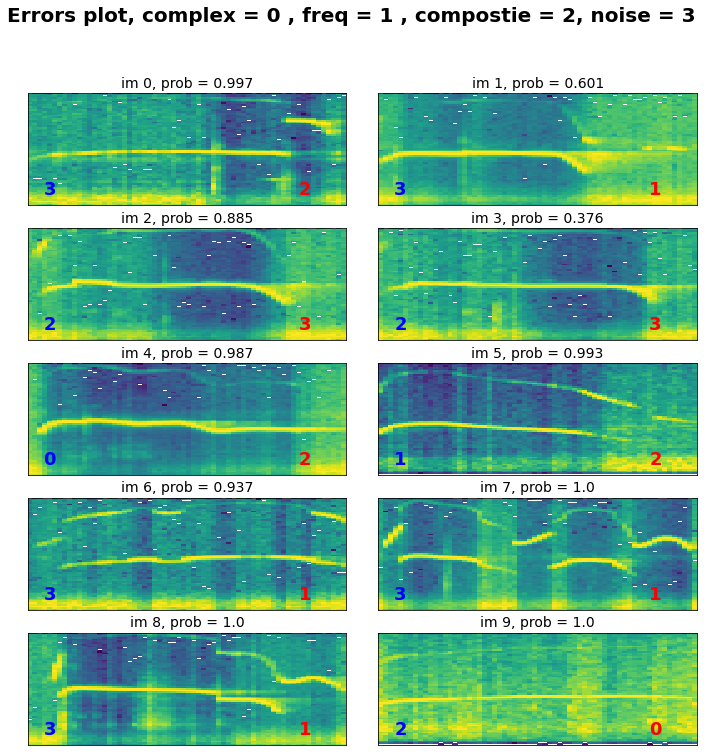

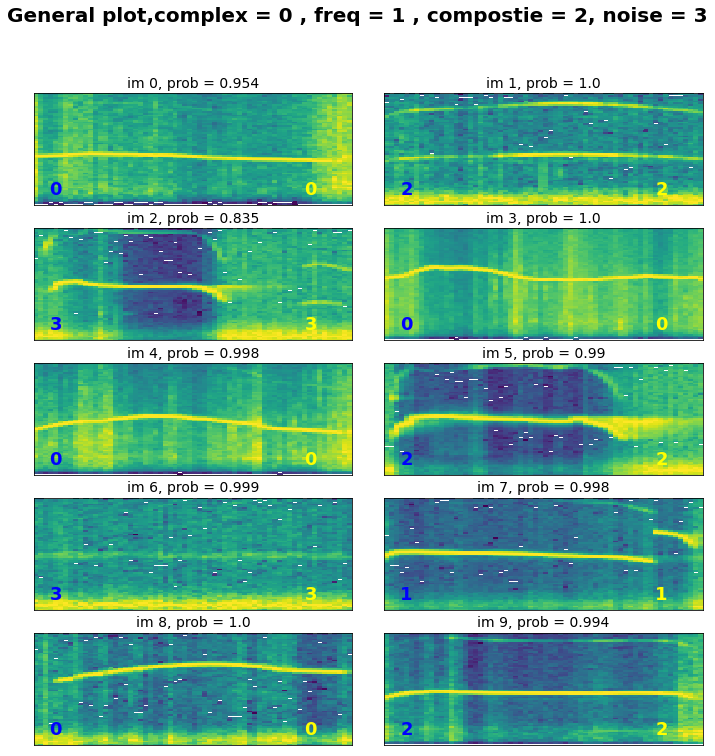

In [ ]:
cm_analysis(y_test, pred, [0,1,2,3],annot_kws={"size": 12})

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,5,2,(12,12),c_pred,title = 'Errors plot, complex = 0 , freq = 1 , compostie = 2, noise = 3',prob = c_prob)
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,5,2,(12,12),pred,title = 'General plot,complex = 0 , freq = 1 , compostie = 2, noise = 3',prob = predictions)


# **Freq Vs complex vs composite vs noise with data augmentation**


In [ ]:
Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
# Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
# two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
# flat_syl = Take_Syllables('flat',Data_united,Labels_united)
# harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
Noise_Labels = 3*np.ones((len(Noise_syl)))

In [ ]:
x = np.concatenate((Complex_syl,Frequency_steps_syl,Composite_syl,Noise_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels,composite_Labels,Noise_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15
print(np.unique(y_train,return_counts = True))
print(np.unique(y_val,return_counts = True))
print(np.unique(y_test,return_counts = True))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
model = build_model(num_classes=4)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        fill_mode='nearest')
hist = model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) / 128, validation_data = (X_val,y_val),
                 shuffle=True, epochs=200,class_weight=class_weights,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))

(array([0., 1., 2., 3.]), array([ 552, 1051,  457,  425]))
(array([0., 1., 2., 3.]), array([110, 207,  94,  99]))
(array([0., 1., 2., 3.]), array([143, 204,  93,  89]))
Epoch 1/200
20/19 [==============================] - 3s 136ms/step - loss: 0.8469 - accuracy: 0.6571 - val_loss: 0.5660 - val_accuracy: 0.8098
Epoch 2/200
20/19 [==============================] - 2s 105ms/step - loss: 0.5384 - accuracy: 0.8189 - val_loss: 0.4608 - val_accuracy: 0.8471
Epoch 3/200
20/19 [==============================] - 2s 106ms/step - loss: 0.4789 - accuracy: 0.8439 - val_loss: 0.4674 - val_accuracy: 0.8588
Epoch 4/200
20/19 [==============================] - 2s 113ms/step - loss: 0.4410 - accuracy: 0.8539 - val_loss: 0.4282 - val_accuracy: 0.8667
Epoch 5/200
20/19 [==============================] - 2s 103ms/step - loss: 0.4024 - accuracy: 0.8700 - val_loss: 0.4088 - val_accuracy: 0.8706
Epoch 6/200
20/19 [==============================] - 2s 103ms/step - loss: 0.3752 - accuracy: 0.8773 - val_loss: 0.3

(array([0, 1, 2, 3]), array([144, 218,  95,  72]))


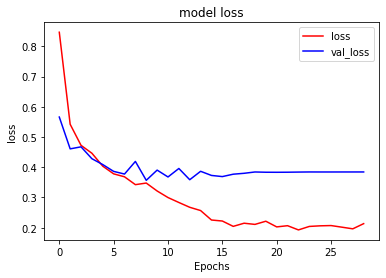

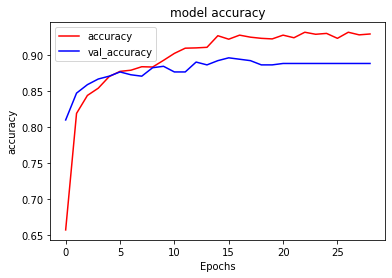

In [ ]:
print_loss(hist)
predictions = model.predict(X_test)
pred = np.argmax(predictions,axis=1)
print(np.unique(pred,return_counts = True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in log10


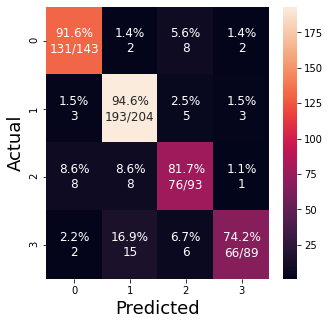

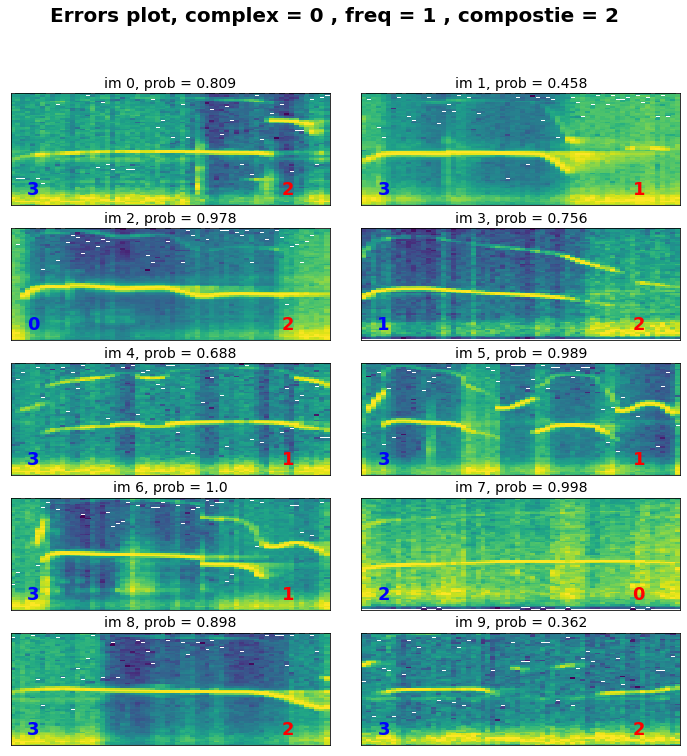

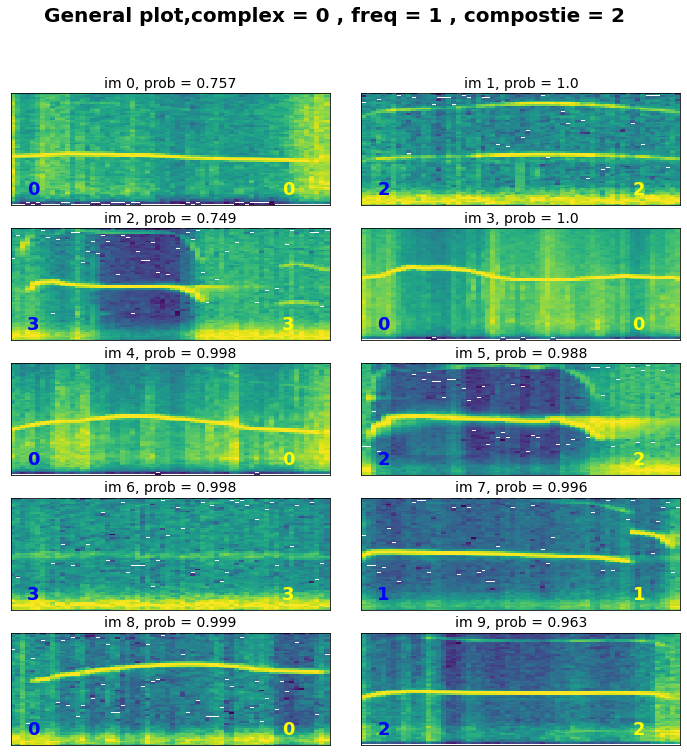

In [ ]:
cm_analysis(y_test, pred, [0,1,2,3],annot_kws={"size": 12})

check = y_test != pred
c = [i for i,j in enumerate(check) if j]
c_test = y_test[c]
c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
c_pred = pred[c]
c_prob = predictions[c]

plot_multiple_imgs(c_x_test,c_test,5,2,(12,12),c_pred,title = 'Errors plot, complex = 0 , freq = 1 , compostie = 2',prob = c_prob)
plot_multiple_imgs(X_test.reshape(X_test.shape[:-1]),y_test,5,2,(12,12),pred,title = 'General plot,complex = 0 , freq = 1 , compostie = 2',prob = predictions)
